In [1]:
import cv2 as cv
import numpy as np
import inspect
import copy
from matplotlib import pyplot as plt
from utils import Splitter
import math
from numpy import uint8

TEST_IMG = "test.jpeg"

In [2]:
# Note: Normally you would convert to grayscale,
#       but I kept color for demonstration

src = cv.imread(TEST_IMG)
if src is None:
    print('Could not open or find the image:', TEST_IMG)
    exit(0)

img = src.copy()
r_split, c_split, split_size = 3, 3, 150
splits = Splitter(img, r_split, c_split, split_size)

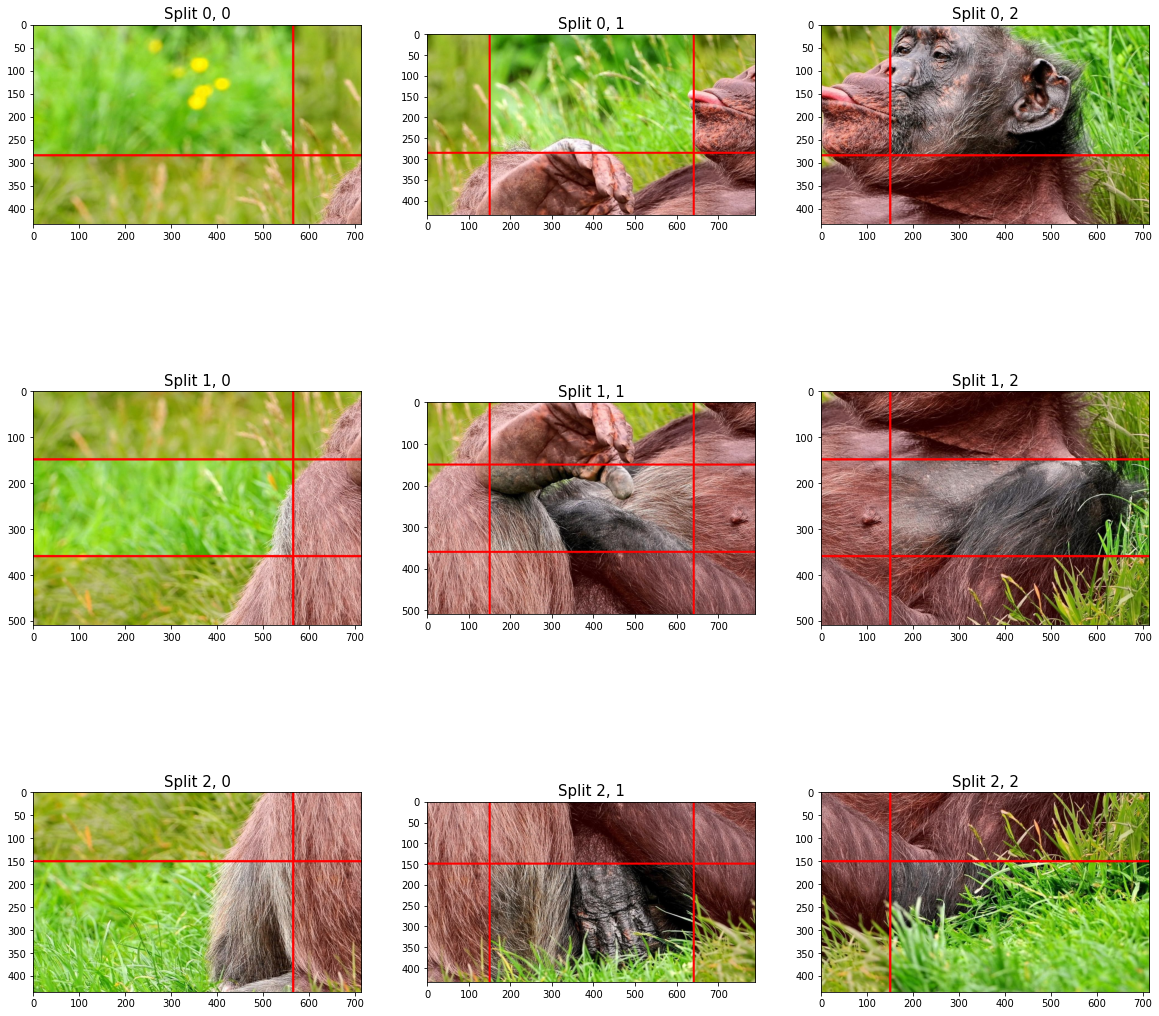

In [3]:
splits.draw_splits(rects=True, alpha=0.15, mod_orig=True)
splits.draw_splits(mod_orig=True)
splits.show()

In [4]:
def SIFT(img, min_s=0, flags=cv.DrawMatchesFlags_DEFAULT, color=-1):
    sift = cv.SIFT_create()
    c_img = img.copy()
    
    kp, des = sift.detectAndCompute(c_img, None)
    kp_des = [v for v in zip(kp, des) if v[0].size >= min_s]

    [kp, des] = zip(*kp_des)
    img = cv.drawKeypoints(
        c_img, kp, img, color=color,
        flags=flags
    )

    return img, (kp, np.array(des))

def pad_y(split1, split2):
    (y1, x1), (y2, x2) = split1.shape[:2], split2.shape[:2]
    if y1 > y2:
        padimg = np.full_like([], 255, shape=(y1, x2, 3), dtype=uint8)
        padimg[0:y2] = split2
        split2 = padimg
    elif y2 > y1:
        padimg = np.full_like([], 255, shape=(y2, x1, 3), dtype=uint8)
        padimg[0:y1] = split1
        split1 = padimg
        
    return split1, split2

def register(sift_data, split1, split2, thresh=0.5):
    split1, split2 = pad_y(split1, split2)
    [(kp1, des1), (kp2, des2)] = sift_data
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test
    matches = np.array(
        [[m] for m, n in matches if m.distance < thresh * n.distance]
    )
    
    # kp registration
    reg = cv.drawMatchesKnn(
        split1, kp1,
        split2, kp2,
        matches, None,
        matchColor = (0, 0, 255),
        flags = cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    # compute H matrix
    if not matches.shape[0]:
        raise AssertionError("No keypoints found")
    if len(matches[:, 0]) >= 5:
        qp = np.float32(
            [kp1[m.queryIdx].pt for m in matches[:, 0]]).reshape(-1,1,2)
        tp = np.float32(
            [kp2[m.trainIdx].pt for m in matches[:, 0]]).reshape(-1,1,2)
        H, _ = cv.findHomography(qp, tp, cv.RANSAC, 5.0)
    else:
        raise AssertionError("Not enough keypoints. \
            Try applying a different transformation")

    return reg, H

def blend(H, sift_data, split1, split2):
    [y1, x1] = split1.shape[:2]
    [y2, x2] = split2.shape[:2]
    # [(kp1, des1), (kp2, des2)] = sift_data    
    
    # define the corners and transform them
    qp = np.float32([[0, 0], [0, y1], [x1, y1], [x1, 0]]).reshape(-1,1,2)
    tp = np.float32([[0, 0], [0, y2], [x2, y2], [x2, 0]]).reshape(-1,1,2)
    tp = cv.perspectiveTransform(tp, H)

    # get max and min points
    pts = np.concatenate((qp, tp), axis = 0)
    [x_min, y_min] = np.int32(pts.min(axis = 0).flatten() - 0.5)
    [x_max, y_max] = np.int32(pts.max(axis = 0).flatten() + 0.5)
    t = [-x_min, -y_min]

    # shift
    Ht = np.array([
        [1, 0, t[0]],
        [0, 1, t[1]],
        [0, 0, 1   ]
    ])

    # transform split2 keypoints, merge them with splits,
    # and transfer them for next match
    # no change desc
    [kpd1, kpd2] = sift_data
    kp = np.float32([p.pt for p in kpd2[0]]).reshape(-1,1,2)
    Hkp = cv.perspectiveTransform(kp, Ht).reshape(-1,2)
    Hd = cv.perspectiveTransform(d, Ht)
    for i, k in enumerate(Hkp):
        kpd2[0][i].pt = tuple(k)
    kp = list(kpd1[0]) + list(kpd2[0])
    d = list(kpd1[1]) + list(kpd2[1])
    # kpd = [*zip(kpd1, kpd2)]
    
    warped = cv.warpPerspective(
        split2, Ht.dot(H), (x_max - x_min, y_max - y_min)
    )
    # need to ignore outlier pixels form right/bot img
    # ex: for pixels in overlap: if pixel is white use left/top img pixel
    warped[t[1]:y1 + t[1], t[0]:x1 + t[0]] = split1
    
    return warped, (kp, d)

In [5]:
def padimg(img):
    (y, x) = img.shape[:2]
    cx, cy = x / 2.0, y / 2.0
    px = math.ceil(math.sqrt(cx ** 2 + cy ** 2)) - int(cx)
    py = math.ceil(math.sqrt(cx ** 2 + cy ** 2)) - int(cy)
    shape = tuple(map(lambda i, j: (i + 2 * j), img.shape, (py, px, 0)))
    outimg = np.full_like([], 255, shape=shape, dtype=uint8)
    outimg[py:-py:, px:-px] = img

    return outimg

def rotation(img, theta_lim=90):
    theta_lim = np.random.uniform(-theta_lim, theta_lim, 1)[0]
    outimg = padimg(img)
    (y, x) = outimg.shape[:2]
    c = (x // 2, y // 2)

    M = cv.getRotationMatrix2D(c, theta_lim, 1.0)
    img = cv.warpAffine(outimg, M, (x, y), borderValue=(255,255,255))
    return img

In [6]:
def scale(img, scale_lim=0.25):
    scale = 1 + np.random.uniform(-scale_lim, scale_lim)
    scale = np.array([scale, scale])
    scale *= img.shape[:2]
    return cv.resize(img, scale.astype(int)[::-1])

In [14]:
def shear(img, limsx=0.25, limsy=0.25):
    low, upp = (0, limsx) if limsx > 0 else (limsx, 0)
    sx = np.random.uniform(low, upp)

    low, upp = (0, limsy) if limsy > 0 else (limsy, 0)
    sy = np.random.uniform(low, upp)
    (y, x) = img.shape[:2]
    
    M = np.float32([
        [1, sy, abs(sy) * y if sy < 0 else 0],
        [sx, 1, abs(sx) * x if sx < 0 else 0]
        ]
    )
    s = (int(x + abs(sy) * y), int(y + abs(sx) * x))
    img = cv.warpAffine(img, M, s, borderValue=(255,255,255))
    return img

In [15]:
sift_kw = {
    "color": (255, 0, 255),
    "thresh": 0.5,
    "min_s": 3
}
rand_transform = [scale, rotation, shear]

splits.restore()
for i in range(r_split):
    for j in range(c_split):
        rand = np.random.randint(0, len(rand_transform))
        transform = rand_transform[rand]
        splits.apply(transform, i, j)

In [16]:
data = splits.apply(SIFT, **sift_kw)
data = [data[i * c_split:i * c_split + c_split] for i in range(r_split)]

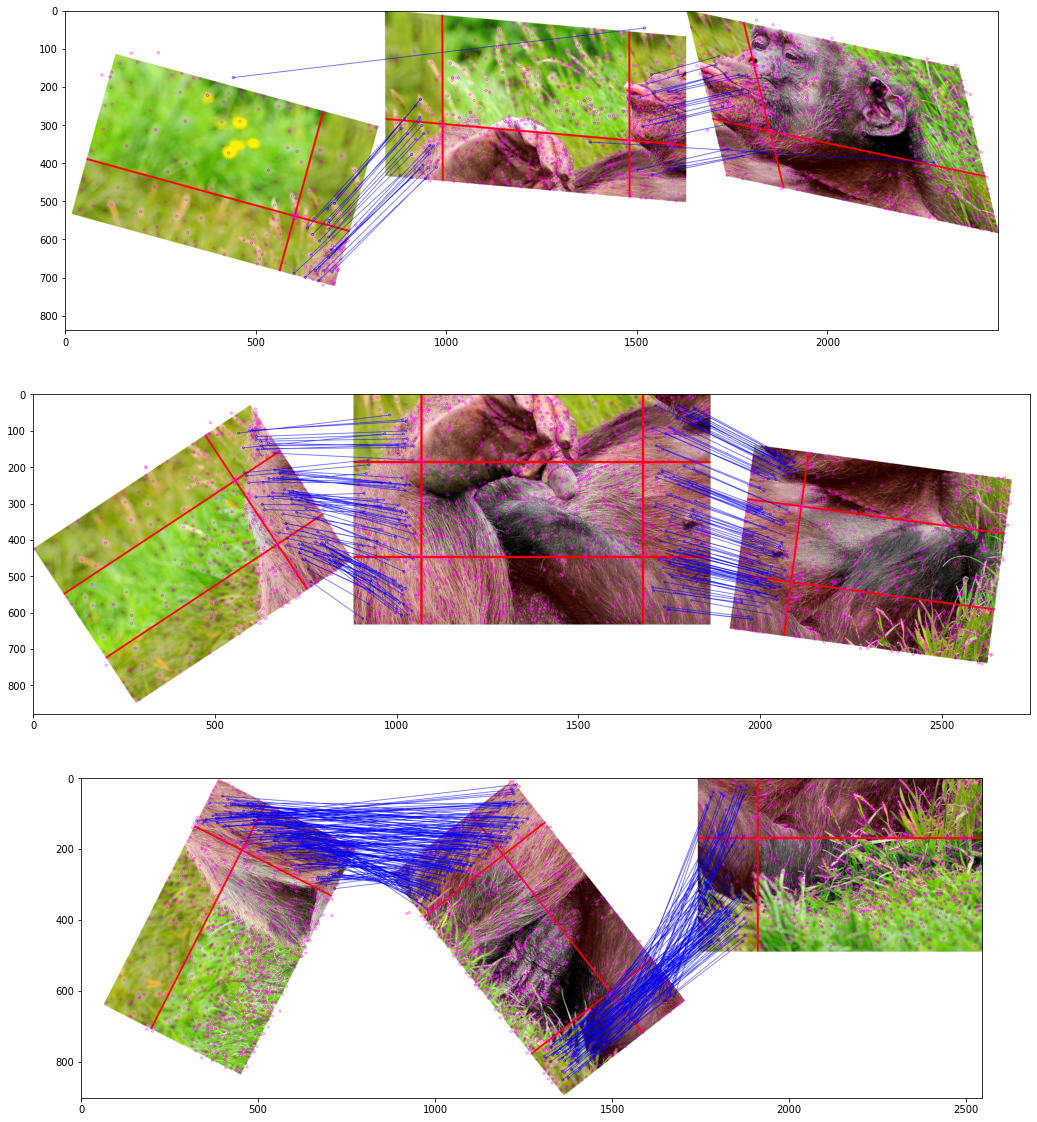

In [29]:
# register rows
# _, axes = plt.subplots(r_split, 1, figsize=(20,20))
# H_mats = [] # H matrix

# for r, data in enumerate(sift_data):
#     res, H = register(data, *splits[r])
#     H_mats.append(H)
#     axes[r].imshow(res)

# copy for displaying
_, axes = plt.subplots(r_split, 1, figsize=(20,20))
c_splits, res, H_mats = copy.deepcopy(splits), [], []

for i, s_row in enumerate(c_splits.mod_splits):
    max_y, H_first = 0, []
    for j in range(c_split - 1):
        s1, s2 = s_row[j], s_row[j + 1]
        res, H = register(data[i][j:j + 2], s1, s2)
        s1, s2 = res[:, :s1.shape[1]], res[:, s1.shape[1]:]
        s_row[j:j + 2] = s1, s2
        H_first.append(H)
        if s1.shape[0] > s_row[max_y].shape[0]: max_y = i
    H_mats.append(H_first[0])
    row = s_row[max_y]
    for j in range(c_split):
        if s_row[j] is row: continue
        row, s_row[j] = pad_y(row, s_row[j])
        row = np.concatenate((row, s_row[j]), axis=1)
    axes[i].imshow(row)



In [42]:
# _, axes = plt.subplots(r_split, 1, figsize=(20,20))
kpds = []
c_splits = copy.deepcopy(splits)

for i, H in enumerate(H_mats):
    for j in range(c_split):
        warped, kpd = blend(H, data[i][:2], *c_splits[i][:2][::-1])
        kpds.append(kpd)
        # axes[i].imshow(warped)
        break

2
2
2
